/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Epoch 1/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.8252 - loss: 0.6349 - val_accuracy: 0.9496 - val_loss: 0.1670
Epoch 2/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 3s 6ms/step - accuracy: 0.9562 - loss: 0.1493 - val_accuracy: 0.9610 - val_loss: 0.1242
Epoch 3/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9705 - loss: 0.0971 - val_accuracy: 0.9697 - val_loss: 0.0957
Epoch 4/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9788 - loss: 0.0694 - val_accuracy: 0.9731 - val_loss: 0.0864
Epoch 5/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9837 - loss: 0.0536 - val_accuracy: 0.9740 - val_loss: 0.0834
Epoch 6/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9861 - loss: 0.0443 - val_accuracy: 0.9747 - val_loss: 0.0838
Epoch 7/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 4ms/step - accuracy: 0.9898 - loss: 0.0340 - val_accuracy: 0.9725 - val_loss: 0.0889
Epoch 8/10
469/469 ━━━━━━━━━━━━━━━━━━━━ 2s 5ms/step - accuracy: 0.9916 - loss: 0.0285 - val_accuracy: 0.

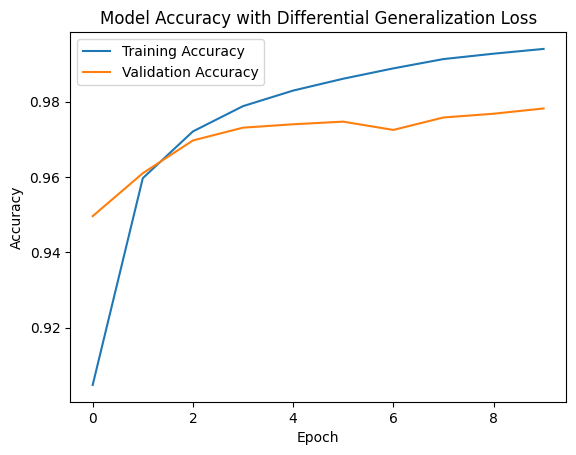

313/313 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step - accuracy: 0.9740 - loss: 0.0967
Test Accuracy: 0.9782


In [4]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers, models
import matplotlib.pyplot as plt

# Load and preprocess MNIST dataset
(x_train, y_train), (x_test, y_test) = tf.keras.datasets.mnist.load_data()
x_train = x_train.astype('float32') / 255.0  # Normalize to [0, 1]
x_test = x_test.astype('float32') / 255.0
y_train = tf.keras.utils.to_categorical(y_train, 10)  # One-hot encode labels
y_test = tf.keras.utils.to_categorical(y_test, 10)

# Define a simple neural network model
model = models.Sequential([
    layers.Flatten(input_shape=(28, 28)),  # Flatten 28x28 images into 784-D vectors
    layers.Dense(128, activation='relu'),  # Hidden layer 1
    layers.Dense(64, activation='relu'),   # Hidden layer 2
    layers.Dense(10, activation='softmax') # Output layer for 10 classes
])

# Custom Differential Generalization Loss (DGL) class
class DifferentialGeneralizationLoss(tf.keras.losses.Loss):
    def __init__(self, lambda_coeff=0.1, name="dgl_loss"):
        super().__init__(name=name)
        self.lambda_coeff = lambda_coeff  # Weight for differential term
        self.cross_entropy = tf.keras.losses.CategoricalCrossentropy()  # Base loss
        self.prev_error = tf.Variable(0.0, trainable=False) # Track previous test error as a tf.Variable

    def call(self, y_true, y_pred):
        # Compute standard Cross-Entropy loss
        trad_loss = self.cross_entropy(y_true, y_pred)

        # Simulate test error using a small validation batch
        test_sample_x, test_sample_y = x_test[:100], y_test[:100]  # Small batch for efficiency
        test_pred = model(test_sample_x, training=False)
        test_error = tf.reduce_mean(tf.keras.losses.categorical_crossentropy(test_sample_y, test_pred))

        # Calculate differential term: |E(t) - E(t-1)|
        diff_term = tf.abs(test_error - self.prev_error)
        self.prev_error.assign(test_error)  # Update previous error using assign

        # Combine traditional loss with differential regularization
        total_loss = trad_loss + self.lambda_coeff * diff_term
        return total_loss

# Compile the model with DGL
model.compile(optimizer='adam',
              loss=DifferentialGeneralizationLoss(lambda_coeff=0.1),
              metrics=['accuracy'])

# Train the model
history = model.fit(x_train, y_train,
                    epochs=10,
                    batch_size=128,
                    validation_data=(x_test, y_test))

# Plot training and validation accuracy
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy with Differential Generalization Loss')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

# Evaluate on test data
test_loss, test_acc = model.evaluate(x_test, y_test)
print(f"Test Accuracy: {test_acc:.4f}")